# Problema 1

item a: Para $M={4,16,64}$, determine a energia média $\varepsilon _{m}$ de cada constelação.

Questão tabelada e teórica. O resultado se encontra na página 105 do Proakis,

$$\varepsilon_{m}=\frac{M-1}{3}\varepsilon_{g}$$

Notando que essa equação é válida para o caso especial $M=4^{n}$ e $d=2$.

item b: Determine a distância mínima $d_{min}$ entre dois símbolos.

Igualmente ao item anterior, é uma questão tabelada e teórica. Resposta se encontra no Proakis, igualmente.

$$d_{min}=\sqrt{2\varepsilon_{g}}$$

$$d_{min}=\sqrt{\frac{6\varepsilon_{avg}}{M-1}}$$

item c: implemente o modulador (mapeamento bit-símbolo) usando a codificação de Gray.

Ok, isso é um pouco difícil. Montar a constelação já é um exercício interessante por si só, e pode ser feito de diversas formas. No entanto, a codificação de Gray precisa seguir uma lógica que possa [that could be *scaled up*] (em inglês é mais fácil expressar isso xd) a qualquer número da forma $M=4^n$ que quisermos. No começo do trabalho, não sabia fazer isso, então fui pesquisar como e achei um método, que acabei implementando. Antes de implementá-lo, já havia gastado um bom tempo programando meu método de fazer a constelação, mas como a implementação do método já incluia a construção da constelação, acabei tendo ignorar o que tinha feito até então e adotar os métodos apresentados na fonte. Segue aqui, primeiro, uma função que nos entrega a constelação base, e outra que nos plota ela. Para alternar entre os valores de M requeridos, basta mudar o valor de $n$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def qamConstellation(M): # gray coding into constellation setup ahead
    n=np.arange(0,M) # symbols from 0 to M-1
    a=np.asarray([x^(x>>1) for x in n]) # convert linear to gray code
    D=np.sqrt(M).astype(int) # dimension of our map
    a=np.reshape(a,(D,D)) # slice array on a matrix D x D sized
    oddRows=np.arange(start=1,stop=D,step=2) # identify rows to flip
    a[oddRows,:]=np.fliplr(a[oddRows,:]) # flip the rows
    nGray=np.reshape(a,(M)) # reshape/flatten to 1xM array
    (x,y)=np.divmod(nGray,D) # element-wise quotient and remainder
    Ax=2*x+1-D
    Ay=2*y+1-D
    constellation = Ax + 1j*Ay
    return constellation

def plotConstellation(constellation,M):
    from math import log2
    fig, axs = plt.subplots(1, 1)
    axs.plot(np.real(constellation),np.imag(constellation),'o')
    for i in range(0,M):
        axs.annotate("{0:0{1}b}".format(i,int(log2(M))),(np.real(constellation[i]),np.imag(constellation[i])))
    axs.set_title('Constellation')
    axs.set_xlabel('I')
    axs.set_ylabel('Q')

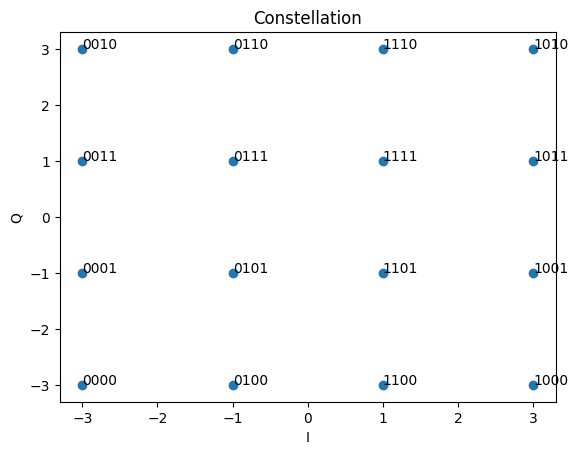

In [2]:
p = 2 # 4 power
M=4**(p) # number of points in QAM

constellation = qamConstellation(M)
plotConstellation(constellation,M)

Inclusive, a codificação de Gray já é inclusa no gráfico. :> É outra coisa que procurei como fazer e tentei implementar, mas acabei tendo que beber da fonte como fazer por causa da montagem da conversão dos valores no annotate. Me refiro a "{0:0{1}b}".format(i,int(log2(M))). Tentei quebrar a cabeça pra fazer isso e não consegui. O meu não mostrava todos os números, então se fosse "0010", sairia só "10". Enfim, adiante!

Ainda não modulamos "em si". A única coisa que fizemos foi criar a constelação. Ainda precisamos gerar a sequência de símbolos e distribuí-la na constelação. Para tal, definimos as seguintes funções.

In [3]:
def modulateMQAM(constellation, num_symbols, M):
    x_int = np.random.randint(0, M, num_symbols) # 0 to M-1 elements
    C=np.zeros(len(x_int)).astype(complex) # [COMPLEX]-zeros vector to put our results in
    for i in np.arange(0,len(x_int),1): # [for]-loop for our calculations -> inputting constellation numbers into our generated input matrix
        C[i]=constellation[x_int[i]]
    return C, x_int

def awgn(C, SNRdB):
    gamma = 10**(SNRdB/10) #SNR to linear scale
    P=np.sum(abs(C)**2)/len(C) # power in the vector -> P=sum (X^{2})/M
    N0=P/gamma # noise spectral density
    n = np.sqrt(N0/2)*(np.random.randn(len(C)) + 1j*np.random.randn(len(C))) # AWGN with unity power
    r = C + n # received signal + noise
    return r

Implementei também como função o ruído. Acho que é mais interessante ver como o ruído se comporta do que ver a constelação se sobrepondo, então é isso que decidi plotar a seguir.

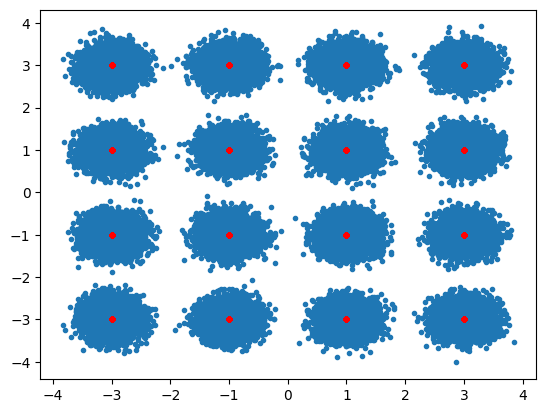

In [4]:
num_symbols = int(1e5) # number of symbols
[C, x_int] = modulateMQAM(constellation,num_symbols,M)
SNRdB=20
r = awgn(C,SNRdB)

fig, axs = plt.subplots(1,1)
axs.plot(np.real(r), np.imag(r), '.')
axs.plot(np.real(C), np.imag(C), '.r')
plt.show()

A seguir temos o demodulador/detector. Nesse ponto eu estava só testando as coisas, então nem pensei como fazer isso, então a implementação vem da fonte que eu venho usando para estudar o assunto.

In [5]:
def chDetector(receivedSyms, constellation): # demodulation scheme - coherent detector on euclidian distance from reference point
    from scipy.spatial.distance import cdist 
    XA=np.column_stack((np.real(receivedSyms),np.imag(receivedSyms))) # received vector in cartesian form
    XB=np.column_stack((np.real(constellation),np.imag(constellation))) # reference vector in cartesian form
    d=cdist(XA,XB,metric='euclidean') # pair wise euclidian distance
    detectedSyms=np.argmin(d,axis=1) # indices corresponding to min. euclidian dist.
    return detectedSyms

In [6]:
p = 2 # 4 power
M=4**(p) # number of points in QAM

constellation = qamConstellation(M)

num_symbols = int(1e5) # number of symbols
[C, x_int] = modulateMQAM(constellation,num_symbols,M)

detectedSyms = chDetector(C,constellation)

print(sum(detectedSyms-x_int))
print('it just works')

0
it just works


Vou parar esse notebook por aqui, uma vez que o pulo da questão 1 pra questão 2 é um pouco grande. Vou tentar investir um pouco mais de tempo tentando fazer do zero, mas caso não consiga vou fazer uso das implementações que achei e é isso. (que já consegui botar pra funcionar... só isso em si já deu um bom trabalho resolvendo os problemas v:)